# Hybrid Recommendation Engine
DonorsChoose.org has funded over 1.1 million classroom requests through the support of 3 million donors, the majority of whom were making their first-ever donation to a public school. If DonorsChoose.org can motivate even a fraction of those donors to make another donation, that could have a huge impact on the number of classroom requests fulfilled. A good solution will enable DonorsChoose.org to build targeted email campaigns recommending specific classroom requests to prior donors.

In [1]:
import warnings
warnings.simplefilter('ignore')

import os
import gc
import pickle
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from tqdm._tqdm_notebook import tqdm_notebook
from multiprocessing import Manager, Process, cpu_count
from scipy import sparse
from nltk.corpus import stopwords

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
sns.set_style('whitegrid')
tqdm_notebook.pandas()

## Loading dataset

In [2]:
start=time.time()
donations=pd.read_csv("data/Donations.csv")
donors=pd.read_csv("data/Donors.csv")
projects=pd.read_csv("data/Projects.csv")
schools=pd.read_csv("data/Schools.csv")
print("Time taken to load data : {:.2f} seconds".format(time.time()-start))

Time taken to load data : 42.27 seconds


## Pre-processing

In [3]:
dfs={
    "donations":donations,
    "donors":donors,
    "projects":projects,
    "schools":schools
}

for name,df in dfs.items():
    columns=df.columns
    print("\n## "+name.upper())
    print('-'*70)
    print('{0:<40}{1:<20}{2:<1}'.format("Column Name","Total","Null"))
    print('-'*70)
    for column in columns:
        total=df[column].shape[0]
        nulls=df[column].isnull().sum()
        print('{0:<40}{1:<20}{2:<10}'.format(column,total,nulls))
    print()


## DONATIONS
----------------------------------------------------------------------
Column Name                             Total               Null
----------------------------------------------------------------------
Project ID                              4687884             0         
Donation ID                             4687884             0         
Donor ID                                4687884             0         
Donation Included Optional Donation     4687884             0         
Donation Amount                         4687884             0         
Donor Cart Sequence                     4687884             0         
Donation Received Date                  4687884             0         


## DONORS
----------------------------------------------------------------------
Column Name                             Total               Null
----------------------------------------------------------------------
Donor ID                                2122640             0  

### POC Sample set
**Here, for proof of concept puprose we are choosing a really small set of the actual dataset.**

In [4]:
dataset_size=200000
_donations=donations.sample(n=dataset_size,random_state=42)
_donors=donors[donors['Donor ID'].isin(_donations['Donor ID'])]
_projects=projects[projects['Project ID'].isin(_donations['Project ID'])]

### Keeping projects with `Project ID`s that are common in `Donations` and `Projects`
Before we move further, we should check if all the `Project ID` in **donations** dataset are present in **projects** dataset. Such difference from both the sets should be removed from the **donations** dataset, because we cannot trace back the project details to build a donor profile.

In [5]:
common_project_ids=list(set(_donations["Project ID"]).intersection(set(_projects["Project ID"])))
_donations=_donations[_donations["Project ID"].isin(common_project_ids)]
_projects=_projects[_projects["Project ID"].isin(common_project_ids)]
print("After dropping the project with no details, donations shape is {}".format(_donations.shape))
print("After dropping the project with no details, projects shape is {}".format(_projects.shape))

After dropping the project with no details, donations shape is (196809, 7)
After dropping the project with no details, projects shape is (158066, 18)


### Merging datasets

In [6]:
_projects=pd.merge(_projects,schools,on='School ID',how='left')
_donations=pd.merge(_donations,_donors[['Donor ID','Donor Is Teacher']],on='Donor ID',how='left')

### Filtering donations by donor who are not teacher
Our recommendation engine should be recommending donors who are not teachers. This is why we should supply only those donations for training model where donor is not a teacher.

In [7]:
_donations.groupby('Donor Is Teacher').size().to_frame(name='count')

,count
Donor Is Teacher,
No,140708
Yes,55845


In [8]:
_donations=_donations[_donations['Donor Is Teacher']=='No']
_donations.shape

(140708, 8)

### Setting new indices

In [9]:
_donors=_donors.set_index('Donor ID')
_projects=_projects.set_index('Project ID')
_donations=_donations.set_index(['Donor ID','Project ID'])

### Unique (Donor,Project) Transformation & Log Transformation
Here, we will aggregate the donations where a single donor donated to same project more than once. Such donations will grouped by `Donor ID` and `Project ID`, and `Donation Amount` will be summed.

In [10]:
def log_transformation(x):
    return np.log(x+1)

_donations['Log Amount']=_donations['Donation Amount']
_donations=_donations.groupby(level=['Donor ID','Project ID'])['Log Amount']\
    .sum()\
    .progress_apply(log_transformation).to_frame()
_donations.head()

,,Log Amount
Donor ID,Project ID,
00000ce845c00cbf0686c992fc369df4,5bab6101eed588c396a59f6bd64274b6,3.931826
00005454366b6b914f9a8290f18f4aed,d82a6d8c82ca51cc1a7bd54bad289169,4.615121
0000a2175753bc165e53c408589a3bd6,2fc5b57c1a29c7489b182e8c49c0621b,3.258097
0000d299ce46c8375f29f7bb792b9eae,45023d76c4a80d90f0f60a80d5a76c9f,3.258097
0001107b9faa5c3bb42cfcecece1d587,1d478d72cda77d1cbe8479ea26130590,2.397895


In [11]:
print("# OF DONORS\t{}".format(
    _donations.index.get_level_values('Donor ID').unique().shape[0])
)
print("# OF PROJECTS\t{}".format(
    _donations.index.get_level_values('Project ID').unique().shape[0])
)

# OF DONORS	118036
# OF PROJECTS	120697


### Train & test split
Here, the test set will only contain the donations that has donors present in the training set.

In [12]:
donations_train,donations_test=train_test_split(_donations,test_size=0.2,random_state=42)
donor_train_ids=donations_train.index.get_level_values(0)
donations_test=donations_test[donations_test.index.get_level_values(0).isin(donor_train_ids)]
print('Donations Train Shape\t{}'.format(donations_train.shape))
print('Donations Test Shape\t{}'.format(donations_test.shape))

Donations Train Shape	(111651, 1)
Donations Test Shape	(5475, 1)


In [13]:
project_train_ids=donations_train.index.get_level_values(1).unique()
project_test_ids=donations_test.index.get_level_values(1).unique()
projects_train= _projects.loc[project_train_ids]
projects_test = _projects.loc[project_test_ids]
print('Projects Train Shape\t{}'.format(projects_train.shape))
print('Projects Test Shape\t{}'.format(projects_test.shape))

Projects Train Shape	(99134, 25)
Projects Test Shape	(5421, 25)


## Building Recommendation Engine
We will try three approaches for building a recommendation engine :
- **Content based filtering**
- **Attribute based clustering**
- **Collaborative filtering**

## 1. Content based filtering
In this approach, we will recommend the list of donors for a new project based on the project similarity between the new project and the existing projects serveral donors has donated to. Here the project similarity is identified by the taking lookig at the content of `Project Title` and `Project Essay`.

**Training Steps :**
- First we will develop a vocabulary from all the existing projects.
- Then we will represent each project with a vector of numbers. Index of each number in this vector will represent the presence of that word from vocbulary. This will be done using TF-IDF vectorizer. We will call such vector *Project Profile* ($PP$).
- Next we will build the donor profile ($DP$) based on the projects donor has donated to. This will be done by calculating the weighted average of project profiles and the log of their donation amounts ($DA$).

$$DP=\frac{PP_1\times log(DA_1)+PP_2\times log(DA_2)+...+PP_n\times log(DA_n)}{log(DA_1)+log(DA_2)+...+log(DA_n)}$$

**Note:** All the donors profiles can then be stored as a pickle for making prediction.

**Predicting Steps :**
- In order to recommend the list of most relevant donors for a new project, we will first create its project profile using the same vocabulary.
- And then we will find the cosine similarity between the new project profile and all the donor profiles. This will be a vectorized implmentation otherwise recommendation will take too long.
- From the second step, we will get a list of similarity scores between the new project and the project interests of all the donors.
- We will then simply choose the top N donors with high similarity score.

### Merging Project and School dataset

In [14]:
attributes_to_consider=[
    "Project Title",
    "Project Essay",
    "Project Subject Category Tree",
    "Project Need Statement",
    "Project Resource Category",
    "School Metro Type"
]

In [15]:
# Load the tfid_vector from pickle file if exist
directory="./features/"
vectorizer_filepath=directory+"tfidf_vectorizer.pickle"
tfidf_matrix_filepath=directory+"tfidf_matrix.pickle"
if not os.path.exists(directory):
    os.makedirs(directory)
if os.path.isfile(vectorizer_filepath) and os.path.isfile(tfidf_matrix_filepath):
    vectorizer=pickle.load(open(vectorizer_filepath,"rb"))
    tfidf_matrix=pickle.load(open(tfidf_matrix_filepath,"rb"))
else:
    # Creating a vocabulary
    text_corpus=''
    for attribute in attributes_to_consider:
        projects_train[attribute]=projects_train[attribute].astype(str)
        projects_train[attribute].fillna('',inplace=True)
        text_corpus+=' '+projects_train[attribute]    
    # Vectorizing the vocabulary
    start=time.time()
    vectorizer=TfidfVectorizer(
        strip_accents='unicode',
        analyzer='word',
        lowercase=True,
        stop_words='english',
        max_df=0.9,
        token_pattern=r'(?u)\b[A-Za-z]+\b'
    )
    tfidf_matrix=vectorizer.fit_transform(text_corpus)
    pickle.dump(vectorizer,open(vectorizer_filepath,"wb"))
    pickle.dump(tfidf_matrix,open(tfidf_matrix_filepath,"wb"))
    print("Time taken to apply TFID on text corpus : {:.2f} seconds".format(time.time()-start))

feature_names=vectorizer.get_feature_names()
tfidf_matrix

Time taken to apply TFID on text corpus : 26.96 seconds


<99134x58851 sparse matrix of type '<class 'numpy.float64'>'
	with 10492499 stored elements in Compressed Sparse Row format>

In [16]:
projects_train_ids=projects_train.index.unique()

def get_project_profile(project_id):
    '''Returns the tfidf vector for the given project ID'''
    idx=projects_train_ids.tolist().index(project_id)
    project_profile=tfidf_matrix[idx:idx+1]
    return project_profile

def get_project_profiles(project_ids):
    '''Returns the tfidf sparse vectors for the given project IDs'''
    project_profiles=[get_project_profile(project_id) for project_id in np.ravel([project_ids])]
    project_profiles=sparse.vstack(project_profiles)
    return project_profiles

def get_donor_profile(df,donor_id):
    project_ids=df.index.values
    log_amounts=df.values
    project_profiles=get_project_profiles(project_ids)
    donor_profile=np.sum(project_profiles.multiply(log_amounts),axis=0)/(np.sum(log_amounts)+1)
    donor_profile=sparse.csr_matrix(normalize(donor_profile))
    return donor_profile

def get_donor_profiles(df):
    '''
    Returns the tfidf vectors for the given donor IDs
    This function will take some time. While converting
    this notebok to python script, its better to use 
    multiprocessing for this function.
    '''
    donor_ids=df.index.get_level_values(level='Donor ID').unique()
    donor_profiles=[
        get_donor_profile(df.loc[donor_id],donor_id) for donor_id in tqdm_notebook(donor_ids)
    ]
    donor_profiles=sparse.vstack(donor_profiles)
    return donor_ids,donor_profiles
    
def train_model(df,save_model=True):
    '''
    Trains the model for {num_donors} donors and 
    saves the tuple (donor_profiles,donor_ids) 
    into a same pickle file.
    '''
    directory='./models/'
    num_donors=len(df.index.get_level_values(0).unique())
    model_filepath=directory+'donor_profiles.pickle'
    if not os.path.exists(directory):
        os.makedirs(directory)    
    if os.path.isfile(model_filepath):
        donor_ids,donor_profiles=pickle.load(open(model_filepath,"rb"))
        print('Profiles for {} donors loaded!'.format(len(donor_ids)))
    else:
        print('Building profiles for {} donors...'.format(num_donors))
        donor_ids,donor_profiles=get_donor_profiles(df)
        pickle.dump((donor_ids,donor_profiles),open(model_filepath,"wb"))
    return (donor_ids,donor_profiles)

### Training
Let's take a look at few of donor profiles which based on their past donations.

In [17]:
donor_ids,donor_profiles=train_model(donations_train)

Building profiles for 95872 donors...


### Donor Profiles

In [18]:
def get_donors_interest(donor_id,top_n=10):
    index=list(donor_ids).index(donor_id)
    tfidf_vector=donor_profiles[index]
    tfidf_vector=tfidf_vector.toarray().reshape(-1)
    donor_interests=pd.DataFrame(
        zip(feature_names,tfidf_vector),
        columns=['Token','Relevance']
    ).sort_values(by='Relevance',ascending=False)
    return donor_interests.head(top_n)

#### Sample Donor Profile 1

In [19]:
get_donors_interest(np.random.choice(donor_ids,1))

,Token,Relevance
30223,listening,0.312746
14002,dinosaurs,0.243086
20513,funny,0.176957
1841,amusements,0.171682
28378,kindergarteners,0.167979
8084,center,0.162881
11760,crises,0.152917
47020,shortages,0.149375
4299,beaches,0.145594
44018,revitalize,0.140235


#### Sample Donor Profile 2

In [20]:
get_donors_interest(np.random.choice(donor_ids,1))

,Token,Relevance
38499,performance,0.292456
51682,task,0.258556
20732,games,0.174715
31970,math,0.157344
10431,conduct,0.155175
17993,experiments,0.147904
45787,science,0.141598
43215,relevancy,0.137696
28524,kits,0.128716
48403,solving,0.123453


### Predicting

In [21]:
def recommend_donors(project,cut_off_percentile=99.9,plot=False):
    '''
    Returns the list of Donor IDs whose similarity score is 
    greater than {score_threshold} defind. Similarity score
    range is greater than 0 and less than 1.
    '''
    start=time.time()
    text=''
    for attribute in attributes_to_consider:
        value=project[attribute].values[0]
        value='' if type(value)==float else value
        text+=value
    project_profile=normalize(vectorizer.transform([text]))
    similarity_scores=cosine_similarity(project_profile,donor_profiles).reshape(-1).astype(np.object)
    recommended_donors=np.column_stack((donor_ids,similarity_scores))
    cut_off=np.percentile(similarity_scores,cut_off_percentile)
    recommended_donors=recommended_donors[recommended_donors[:,1]>cut_off]
    recommended_donors=recommended_donors[recommended_donors[:,1].argsort()[::-1]]
    end=time.time()
    if plot:
        print('Time taken to recommend donors : {:.2f} seconds'.format(end-start))
        print('Score cut-off : {}'.format(cut_off))
        print('Project ID : {}'.format(project.index[0]))
        ax=sns.distplot(similarity_scores,kde=False,color='red',rug=True)
        ax.set(xlabel='Similarity Score', ylabel='# of Donors')
    return recommended_donors

#### Recommendation on projects the recommender was trained on!
Here the defualt `cut_off` of **0.70** is used.

Time taken to recommend donors : 0.60 seconds
Score cut-off : 0.4775028350093095
Project ID : 4e67cc011530bea40e2bf3dc6d52ecec
----------------------------------------------------------------------------------------------------
ACTUAL DONORS :
                           Donor ID     Score Donor City Donor State Donor Is Teacher Donor Zip
0  cf835710daa526f9549618208a54875d  0.999058        Ada    Michigan               No       493
----------------------------------------------------------------------------------------------------
RECOMMENDED DONORS :
                           Donor ID     Score Donor City Donor State Donor Is Teacher Donor Zip
0  cf835710daa526f9549618208a54875d  0.999058        Ada    Michigan               No       493


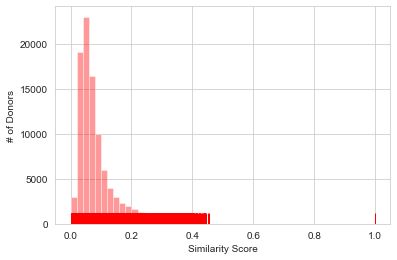

In [22]:
index=np.random.choice(range(projects_train.shape[0]),size=1)[0]
project=projects_train.iloc[index:index+1]
recommended_donors=recommend_donors(
    project,
    cut_off_percentile=99.999,
    plot=True
)
recommended_donors=pd.DataFrame(
    recommended_donors,
    columns=['Donor ID','Score']
)
print('-'*100)
print('ACTUAL DONORS :')
actual_donors=donors[donors['Donor ID'].isin(donations_train.xs(project.index[0],level=1).index.values)]
actual_donors=pd.merge(actual_donors['Donor ID'],recommended_donors,on='Donor ID',how='left')
actual_donors=pd.merge(actual_donors,donors,on='Donor ID',how='left')
print(actual_donors)
print('-'*100)
print('RECOMMENDED DONORS :')
recommended_donors=pd.merge(recommended_donors,donors,on='Donor ID',how='left')
print(recommended_donors.head(10))

#### Recommendation on projects NOT trained on!
Here the `score_threshold` of around 0.5 is used. The reason why we are using a lower `score_threshold` is because we have trained on a smaller training set. So recommedation engine has seen very less number of projects and might not be able to give similarity score greater than 0.7 for every new project.

Time taken to recommend donors : 0.73 seconds
Score cut-off : 0.21008769407369915
Project ID : fa2d418bf91132bff41c60e9871df448
----------------------------------------------------------------------------------------------------
ACTUAL DONORS :
                           Donor ID Score Donor City     Donor State Donor Is Teacher Donor Zip
0  d91045898a153114cc2ff5d454573f61   NaN      Arden  North Carolina               No       287
----------------------------------------------------------------------------------------------------
RECOMMENDED DONORS :
                           Donor ID     Score        Donor City Donor State Donor Is Teacher Donor Zip
0  7c169c820abc784a6b92577fa13949db   0.32328               NaN       other               No       NaN
1  32f656a00b055cf9588d0eb8ec6f69a7   0.28335          Imperial    Missouri               No       630
2  8710e8f57714bd5f33c4d000297550ec  0.268946         Frederick    Maryland               No       217
3  5d87e37fe133ecc0b1d4bbac80

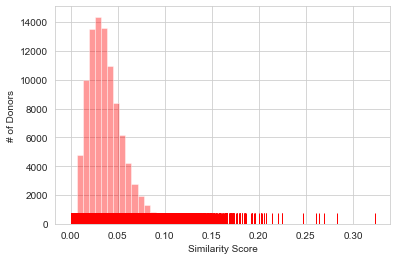

In [23]:
index=np.random.choice(range(projects_test.shape[0]),size=1)[0]
project=projects_test.iloc[index:index+1]
recommended_donors=recommend_donors(
    project,
    cut_off_percentile=99.99,
    plot=True
)
recommended_donors=pd.DataFrame(
    recommended_donors,
    columns=['Donor ID','Score']
)
print('-'*100)
print('ACTUAL DONORS :')
actual_donors=donors[donors['Donor ID'].isin(donations_test.xs(project.index[0],level=1).index.values)]
actual_donors=pd.merge(actual_donors['Donor ID'],recommended_donors,on='Donor ID',how='left')
actual_donors=pd.merge(actual_donors,donors,on='Donor ID',how='left')
print(actual_donors)
print('-'*100)
print('RECOMMENDED DONORS :')
recommended_donors=pd.merge(recommended_donors,donors,on='Donor ID',how='left')
print(recommended_donors.head(10))

### Evaluating
In this section, we will calculate
- **Precision@k**
$$
\boxed{
\text{Precision@k}=\frac
{\text{# of recommended donors @k that are relevant}}
{\text{# of recommended donors @k}}
}
$$
- **Recall@k**
$$
\boxed{
\text{Recall@k}=\frac
{\text{# of recommended donors @k that are relevant}}
{\text{Total # of relevant donors}}
}
$$

for projects which are
- part of the training set.
- new to the recommendation engine. Here we will only use those donors as the recommended donors for which our recommendation engine has those profiles.

In [24]:
def precision_recall_K(donations,projects,K,cut_off_percentile=99.99):
    accuracy={
        "precision":{},
        "recall":{},
        "f1":{}
    }
    print('Evaluating the model...')
    for i in tqdm_notebook(range(projects.shape[0])):
        project=projects.iloc[i:i+1]
        project_id=project.index.values[0]
        relevant=donations.xs(project_id,level=1).index.values
        recommended=recommend_donors(project,cut_off_percentile)[:,0]
        for k in K:
            recommended_k=recommended[:k]
            recommneded_relevant_k=list(set(recommended_k).intersection(set(relevant)))
            # Precision
            if len(recommended_k)==0 and len(relevant)==0:
                precision=1
            elif len(recommended_k)==0 and len(relevant)!=0:
                precision=0
            else:
                precision=len(recommneded_relevant_k)/len(recommended_k)
            if accuracy['precision'].get(k,None)==None:
                  accuracy['precision'][k]=[]
            accuracy['precision'][k].append(precision)
            # Recall
            if len(relevant)==0 and len(recommended_k)==0:
                recall=1
            elif len(relevant)==0 and len(recommended_k)!=0:
                recall=0
            else:
                recall=len(recommneded_relevant_k)/len(relevant)
            if accuracy['recall'].get(k,None)==None:
                  accuracy['recall'][k]=[]
            accuracy['recall'][k].append(recall)
            # f1 score
            if precision==0 and recall==0:
                f1=0
            else:
                f1=(2*precision*recall)/(precision+recall)
            if accuracy['f1'].get(k,None)==None:
                accuracy['f1'][k]=[]
            accuracy['f1'][k].append(f1)
    for k in K:
        accuracy['precision'][k]=np.mean(accuracy['precision'][k])
        accuracy['recall'][k]=np.mean(accuracy['recall'][k])
        accuracy['f1'][k]=np.mean(accuracy['f1'][k])
    accuracy=pd.DataFrame({
        "k":K,
        "precision":list(accuracy['precision'].values()),
        "recall":list(accuracy['recall'].values()),
        "f1":list(accuracy['f1'].values())
    })
    return accuracy

#### On training set

Evaluating the model...


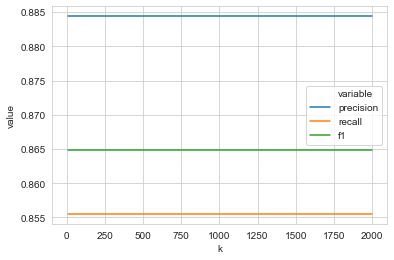

In [27]:
train_sample_size=5000
K=[5,10,20,50,100,500,1000,2000]
accuracy=precision_recall_K(
    donations_train,
    projects_train.sample(n=train_sample_size,random_state=42),
    K,cut_off_percentile=99.999
)
# Plotting accuracy
plt=sns.lineplot(x='k',y='value',hue='variable',data=pd.melt(accuracy,['k']));
fig=plt.get_figure()
fig.savefig('images/train_accuracy_{}_{}.png'.format(len(donor_ids),train_sample_size))

#### On test set

Evaluating the model...


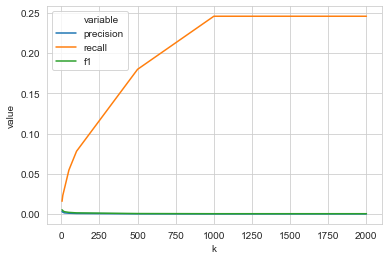

In [28]:
test_sample_size=5000
K=[5,10,20,50,100,500,1000,2000]
accuracy=precision_recall_K(
    donations_test,
    projects_test.sample(n=test_sample_size,random_state=42),
    K,cut_off_percentile=99
)
# Plotting accuracy
plt=sns.lineplot(x='k',y='value',hue='variable',data=pd.melt(accuracy,['k']));
fig=plt.get_figure()
fig.savefig('images/test_accuracy_{}_{}.png'.format(len(donor_ids),test_sample_size))